# 1-Import Data

In [1]:
# import numpy as np
# import pandas as pd
# from ipywidgets import GridBox, Layout

import fileselector as fs
from importlib import reload
reload(fs)
fs.load_dependencies()
# Usage
# Replace '/your/start/directory/' with your actual start directory
Path='/home/coder/project/doric_fiberphotometry/Data/knob'

file_selector = fs.FileSelector(Path)
# file_name = file_selector.get_selected_file()


Dropdown(description='Select File:', options=('Select a file', '258_NAc_knob_Apr18_0000_144628942_incomplete.d…

Selected file: /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete.doric
loading dataset .....


GridBox(children=(Dropdown(description='Isos:', index=7, layout=Layout(height='100px', width='100%'), options=…

Button(description='Load Data', layout=Layout(display='none'), style=ButtonStyle())

Not all datasets were automatically selected, please review and select manually.
Datasets loaded.


ipympl is installed. You can proceed with %matplotlib ipympl.
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//raw_data_seperated.png


/home/coder/project/doric_fiberphotometry/dataexplorer.py:390: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/coder/project/doric_fiberphotometry/dataexplorer.py:402: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(save_path_input.value, dpi=300, bbox_inches='tight')


Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//raw_data_merged.png


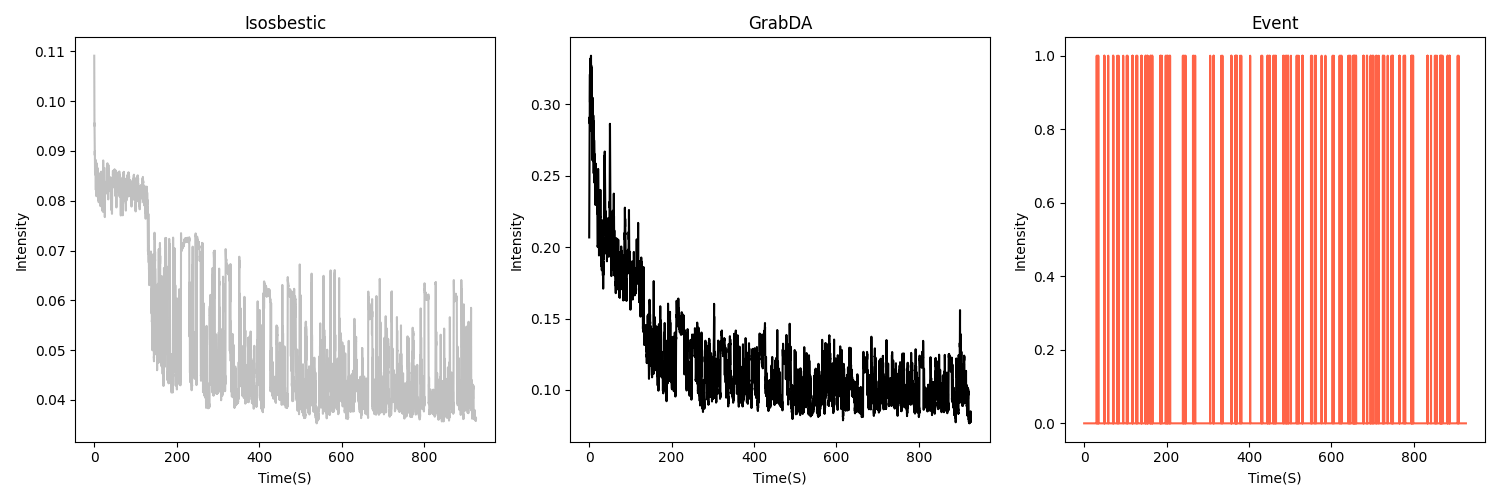

/usr/local/lib/python3.9/dist-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


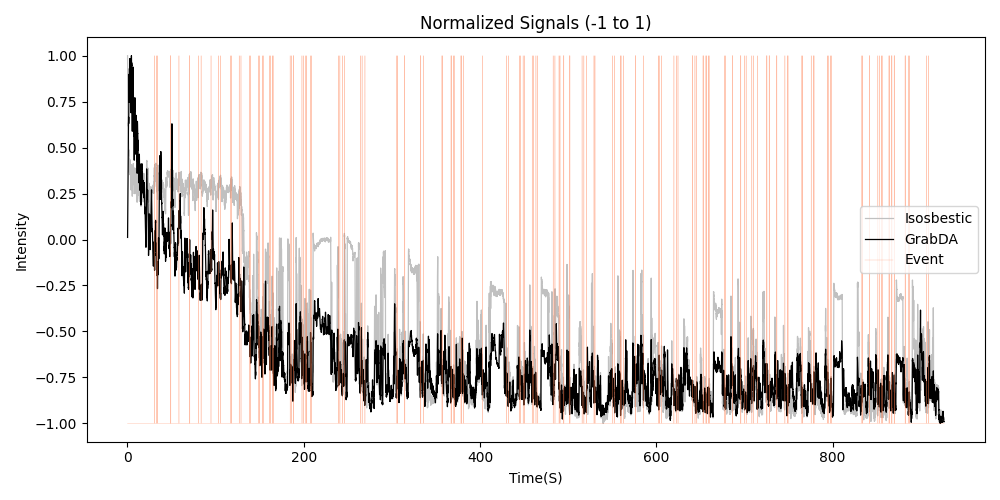

/usr/local/lib/python3.9/dist-packages/ipympl/backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)


In [2]:
## After selecting datasets, the respective info will be displayed.
## Then, click "Load Data" button to load the datasets.
isos_df = file_selector.get_isos_df()
grabda_df = file_selector.get_grabda_df()
event_df = file_selector.get_event_df()

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import dataexplorer as de
from importlib import reload
try:
    import ipympl
    print("ipympl is installed. You can proceed with %matplotlib ipympl.")
    %matplotlib widget
except ImportError:
    print("ipympl is not installed. Please run !pip install ipympl.")
    %pip install ipympl
    %matplotlib widget


reload(de)

de.plot_and_save_seperated(isos_df, grabda_df, event_df,file_selector)

de.plot_and_save(isos_df,grabda_df,event_df,file_selector)



# Knob Events


In [3]:
import dataexplorer as de
from importlib import reload
import ipywidgets as widgets
from IPython.display import display
reload(de)

rising_edges = event_df['Data'].diff() == 1
rising_edge_df = event_df[rising_edges].reset_index().rename(columns={'index': 'Sample_Number'})
## Calculate the optimal time window
optimal_window = de.find_optimal_time_window(rising_edge_df,Event_type='Knob')
print("optimal window is :",optimal_window)
## Classify events in the rising_edge_df
# classified_events_df = de.classify_events(rising_edge_df,optimal_window,['Init','Success','Fail'])
classified_events_df = de.classify_events(rising_edge_df,optimal_window,Event_type='knob')

print(classified_events_df.head())
print("Event Number: ",len(classified_events_df))


optimal window is : 0.035
      Time     Type  Sample_Number
0  30.3952     Init       303952.0
1  30.5024  Success       305024.0
2  33.1788     Init       331788.0
3  34.2453  Success       342453.0
4  48.6110     Init       486110.0
Event Number:  174


In [4]:
classified_events_df.head(12)

,Time,Type,Sample_Number
0,30.3952,Init,303952.0
1,30.5024,Success,305024.0
2,33.1788,Init,331788.0
3,34.2453,Success,342453.0
4,48.6110,Init,486110.0
5,49.0748,Success,490748.0
6,58.3341,Init,583341.0
7,58.3834,Success,583834.0
8,70.0486,Init,700486.0
9,70.6081,Success,706081.0


# Data Prepration


##  Use function get_zdFF to calculate z-dF/F

Download photometry_functions.py file from [here](https://github.com/katemartian/Photometry_data_processing "source").

please cite Jove paper:

__Martianova, E., Aronson, S., Proulx, C.D.__ [Multi-Fiber Photometry to Record Neural Activity in Freely Moving Animal.](https://www.jove.com/video/60278/multi-fiber-photometry-to-record-neural-activity-freely-moving). _J. Vis. Exp._ (152), e60278, doi:10.3791/60278 (2019).

[refrence](https://colab.research.google.com/github/katemartian/Photometry_data_processing/blob/master/Photometry_data_processing.ipynb#scrollTo=Lak9o-Hn3QQW)


In [5]:
from importlib import reload
import photometry_functions as pf
reload(pf)
# Usage
def save_signal(zdff):
    global signal_df 
    signal_df = zdff
    
    print(signal_df.head())
analysis = pf.PhotometryAnalysis(isos_df,grabda_df,save_signal)



IntText(value=10, description='Cutoff Freq:')

IntText(value=0, description='remove(ms):')

FloatLogSlider(value=500000000000.0, description='lambd:', max=16.0, min=5.0)

IntText(value=10, description='porder:')

IntText(value=50, description='itermax:')

Button(description='Run Function', style=ButtonStyle())

Output()

# PSTH Prepration

## Cut and Center the Data

I need 4 types 

1-success after success (sas)
2-success after fail (saf)
3-fail after success (fas)
4-fail after fail (faf)



In [6]:
# Create a new column for the tags
classified_events_df['Tag'] = ''

# Initialize a variable to keep track of the previous type
prev_type = None

# Iterate through the DataFrame
for i in range(len(classified_events_df)):
    curr_type = classified_events_df.at[i, 'Type']
    
    # Tag all "Init" events as "Init"
    if curr_type == 'Init':
        tag = 'Init'
    else:
        # Calculate the tag for "Init" and "Fail" based on previous "Success" or "Fail" events
        if prev_type == 'Fail':
            if curr_type == 'Success':
                tag = 'SAF'
            else:
                tag = 'FAF'
        else:
            if curr_type == 'Success':
                tag = 'SAS'
            else:
                tag = 'FAS'
        # else:
        #     tag = 'NA'
        # Update prev_type for the next iteration
        prev_type = curr_type

    # Assign the tag to the current row
    classified_events_df.at[i, 'Tag'] = tag


    
classified_events_df['Type'] = classified_events_df['Tag']

# Display the updated DataFrame
print(classified_events_df)


         Time  Type  Sample_Number   Tag
0     30.3952  Init       303952.0  Init
1     30.5024   SAS       305024.0   SAS
2     33.1788  Init       331788.0  Init
3     34.2453   SAS       342453.0   SAS
4     48.6110  Init       486110.0  Init
..        ...   ...            ...   ...
169  882.5766   FAF      8825766.0   FAF
170  886.4001  Init      8864001.0  Init
171  887.4258   FAF      8874258.0   FAF
172  906.7107  Init      9067107.0  Init
173  908.7225   FAF      9087225.0   FAF

[174 rows x 4 columns]


In [7]:
print(classified_events_df.Tag)

0      Init
1       SAS
2      Init
3       SAS
4      Init
       ... 
169     FAF
170    Init
171     FAF
172    Init
173     FAF
Name: Tag, Length: 174, dtype: object


In [11]:
import photometry_functions as pf
from importlib import reload

reload(pf)

# Example usage:
time_window = (-5, 10)  # For example, 2 seconds before and after the event


event_type = "Init"  # Use "All" to process all events, or specify a particular type like 'Init'
centralized_signals_df_Init = pf.cut_and_center_signals_modified(signal_df, classified_events_df, time_window, event_type)
print(centralized_signals_df_Init.head())

event_type = "FAF"  # Use "All" to process all events, or specify a particular type like 'Init'
centralized_signals_df_FAF = pf.cut_and_center_signals_modified(signal_df, classified_events_df, time_window, event_type)
print(centralized_signals_df_FAF.head())

event_type = "FAS"  # Use "All" to process all events, or specify a particular type like 'Init'
centralized_signals_df_FAS = pf.cut_and_center_signals_modified(signal_df, classified_events_df, time_window, event_type)
print(centralized_signals_df_FAS.head())

event_type = "SAF"  # Use "All" to process all events, or specify a particular type like 'Init'
centralized_signals_df_SAF = pf.cut_and_center_signals_modified(signal_df, classified_events_df, time_window, event_type)
print(centralized_signals_df_SAF.head())

event_type = "SAS"  # Use "All" to process all events, or specify a particular type like 'Init'
centralized_signals_df_SAS = pf.cut_and_center_signals_modified(signal_df, classified_events_df, time_window, event_type)
print(centralized_signals_df_SAS.head())

 

            Time      Data
Event Row                 
1     2530 -5.00  0.033770
      2531 -4.99  0.030930
      2532 -4.98  0.027656
      2533 -4.97  0.022860
      2534 -4.96  0.014539
             Time      Data
Event Row                  
1     18069 -5.00 -0.607156
      18070 -4.99 -0.605088
      18071 -4.98 -0.597695
      18072 -4.97 -0.583962
      18073 -4.96 -0.565036
             Time      Data
Event Row                  
1     12364 -5.00 -1.155725
      12365 -4.99 -1.164367
      12366 -4.98 -1.170295
      12367 -4.97 -1.172741
      12368 -4.96 -1.171833
             Time      Data
Event Row                  
1     13447 -5.00 -1.088011
      13448 -4.99 -1.062909
      13449 -4.98 -1.042805
      13450 -4.97 -1.028857
      13451 -4.96 -1.019811
            Time      Data
Event Row                 
1     2540 -5.00 -0.075987
      2541 -4.99 -0.096944
      2542 -4.98 -0.123104
      2543 -4.97 -0.151538
      2544 -4.96 -0.179682


## cut signal around Init

In [10]:
# Example usage:
time_window = (-4, 10)  # For example, 2 seconds before and after the event
event_type = "Init"  # Use "All" to process all events, or specify a particular type like 'Init'
centralized_signals_df_Init = pf.cut_and_center_signals(signal_df, classified_events_df, time_window, event_type)
print(centralized_signals_df_Init.head())

event_type = "Success"  # Use "All" to process all events, or specify a particular type like 'Init'
centralized_signals_df_Success = pf.cut_and_center_signals(signal_df, classified_events_df, time_window, event_type)
print(centralized_signals_df_Success.head())

event_type = "Fail"  # Use "All" to process all events, or specify a particular type like 'Init'
centralized_signals_df_Fail = pf.cut_and_center_signals(signal_df, classified_events_df, time_window, event_type)
print(centralized_signals_df_Fail.head())


            Time      Data
Event Row                 
1     2630 -4.00  0.410124
      2631 -3.99  0.449381
      2632 -3.98  0.481632
      2633 -3.97  0.511964
      2634 -3.96  0.547364


ValueError: No objects to concatenate

## Plot Dataset

### Plot all Signals 

In [ ]:
import os
# Plot All signals
y_min = -2
y_max = 4

import photometry_functions as pf
from importlib import reload
reload(pf)





# Init:
fig = plt
pf.plot_cut_signals(centralized_signals_df_Init,y_min,y_max)
# plot_cut_signals(filtered_signal_df)
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/all_Inits.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

# FAF:
fig = plt
pf.plot_cut_signals(centralized_signals_df_FAF,y_min,y_max)
# plot_cut_signals(filtered_signal_df)
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/all_FAF.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

# FAS:
fig = plt
pf.plot_cut_signals(centralized_signals_df_FAS,y_min,y_max)
# plot_cut_signals(filtered_signal_df)
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/all_FAS.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

# FAS:
fig = plt
pf.plot_cut_signals(centralized_signals_df_FAS,y_min,y_max)
# plot_cut_signals(filtered_signal_df)
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/all_FAS.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

# SAS:
fig = plt
pf.plot_cut_signals(centralized_signals_df_SAS,y_min,y_max)
# plot_cut_signals(filtered_signal_df)
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/all_SAS.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")



### Plot Signals seperatly

In [ ]:
y_max=5
y_min=-2

import photometry_functions as pf
from importlib import reload

reload(pf)

# Init
pf.plot_cut_signals_seperated(centralized_signals_df_Init,y_min,y_max)

fig = plt
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/Separeted_Init_Events.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

# Success
pf.plot_cut_signals_seperated(centralized_signals_df_Success,y_min,y_max)

fig = plt
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/Separeted_Success_Events.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

# Fail
pf.plot_cut_signals_seperated(centralized_signals_df_Fail,y_min,y_max)

fig = plt
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/Separeted_Fail_Events.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

### Plot and Select Signals for PSTH

In [12]:

import photometry_functions as pf
from importlib import reload
import os

reload(pf)

# Example usage:

def handle_filtered_data(df,event_type):
    # Handle the filtered DataFrame here, e.g., save it to a global variable or process it further
    if event_type == 'Init':    
        global filtered_signal_df_Init
        filtered_signal_df_Init = df
        print(filtered_signal_df_Init.head())
    
    if event_type == 'FAF':    
        global filtered_signal_df_FAF
        filtered_signal_df_FAF = df
        print(filtered_signal_df_FAF.head())
    
    if event_type == 'FAS':    
        global filtered_signal_df_FAS
        filtered_signal_df_FAS = df
        print(filtered_signal_df_FAS.head())
    
    if event_type == 'SAF':    
        global filtered_signal_df_SAF
        filtered_signal_df_SAF = df
        print(filtered_signal_df_SAF.head())
    
    if event_type == 'SAS':    
        global filtered_signal_df_SAS
        filtered_signal_df_SAS = df
        print(filtered_signal_df_SAS.head())
    
    
    fig = plt
    filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/Selected_Stim_Events_'+event_type+'.png'

    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)

    fig.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Figure saved as {filename}")



# Init:
explorer = pf.SignalExplorer(centralized_signals_df_Init,'Init', save_callback=handle_filtered_data)
# This will display the widgets and allow interaction

# FAF:
explorer = pf.SignalExplorer(centralized_signals_df_FAF,'FAF', save_callback=handle_filtered_data)
# This will display the widgets and allow interaction

# FAS:
explorer = pf.SignalExplorer(centralized_signals_df_FAS,'FAS', save_callback=handle_filtered_data)
# This will display the widgets and allow interaction

# SAF:
explorer = pf.SignalExplorer(centralized_signals_df_SAF,'SAF', save_callback=handle_filtered_data)
# This will display the widgets and allow interaction

# SAS:
explorer = pf.SignalExplorer(centralized_signals_df_SAS,'SAS', save_callback=handle_filtered_data)
# This will display the widgets and allow interaction


GridspecLayout(children=(Checkbox(value=False, description='Select All', layout=Layout(grid_area='widget001'))…

Button(description='Apply Selection', style=ButtonStyle())

Output()

GridspecLayout(children=(Checkbox(value=False, description='Select All', layout=Layout(grid_area='widget001'))…

Button(description='Apply Selection', style=ButtonStyle())

Output()

GridspecLayout(children=(Checkbox(value=False, description='Select All', layout=Layout(grid_area='widget001'))…

Button(description='Apply Selection', style=ButtonStyle())

Output()

GridspecLayout(children=(Checkbox(value=False, description='Select All', layout=Layout(grid_area='widget001'))…

Button(description='Apply Selection', style=ButtonStyle())

Output()

GridspecLayout(children=(Checkbox(value=False, description='Select All', layout=Layout(grid_area='widget001'))…

Button(description='Apply Selection', style=ButtonStyle())

Output()

Filtered data is ready.
            Time      Data
Event Row                 
1     2530 -5.00  0.033770
      2531 -4.99  0.030930
      2532 -4.98  0.027656
      2533 -4.97  0.022860
      2534 -4.96  0.014539
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_Init.png


Filtered data is ready.
             Time      Data
Event Row                  
1     18069 -5.00 -0.607156
      18070 -4.99 -0.605088
      18071 -4.98 -0.597695
      18072 -4.97 -0.583962
      18073 -4.96 -0.565036
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_FAF.png


Filtered data is ready.
             Time      Data
Event Row                  
1     12364 -5.00 -1.155725
      12365 -4.99 -1.164367
      12366 -4.98 -1.170295
      12367 -4.97 -1.172741
      12368 -4.96 -1.171833
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_FAS.png


Filtered data is ready.
             Time      Data
Event Row                  
1     13447 -5.00 -1.088011
      13448 -4.99 -1.062909
      13449 -4.98 -1.042805
      13450 -4.97 -1.028857
      13451 -4.96 -1.019811
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_SAF.png


Filtered data is ready.
            Time      Data
Event Row                 
1     2540 -5.00 -0.075987
      2541 -4.99 -0.096944
      2542 -4.98 -0.123104
      2543 -4.97 -0.151538
      2544 -4.96 -0.179682
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_SAS.png


Filtered data is ready.
             Time      Data
Event Row                  
3     18339 -5.00 -0.117667
      18340 -4.99 -0.112099
      18341 -4.98 -0.107501
      18342 -4.97 -0.103346
      18343 -4.96 -0.097788
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_SAF.png


Filtered data is ready.
             Time      Data
Event Row                  
1     13447 -5.00 -1.088011
      13448 -4.99 -1.062909
      13449 -4.98 -1.042805
      13450 -4.97 -1.028857
      13451 -4.96 -1.019811
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_SAF.png


Filtered data is ready.
             Time      Data
Event Row                  
3     16011 -5.00  0.042781
      16012 -4.99  0.047709
      16013 -4.98  0.061347
      16014 -4.97  0.080928
      16015 -4.96  0.102351
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_FAS.png


Filtered data is ready.
            Time      Data
Event Row                 
3     4397 -5.00 -0.064170
      4398 -4.99 -0.045246
      4399 -4.98 -0.022047
      4400 -4.97  0.002364
      4401 -4.96  0.025362
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_SAS.png


Filtered data is ready.
            Time      Data
Event Row                 
4     5328 -5.00 -0.065495
      5329 -4.99 -0.083843
      5330 -4.98 -0.108235
      5331 -4.97 -0.134255
      5332 -4.96 -0.156504
Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs//Selected_Stim_Events_SAS.png


## Normalization

In [16]:
import photometry_functions as pf
from importlib import reload

reload(pf)


# Init:
# Assuming 'Data' is the column in filtered_signal_df that you want to normalize
# normalized_signal_df_Init = pf.normalize_signal(filtered_signal_df_Init, column='Data')
normalized_signal_df_Init = filtered_signal_df_Init

# Assuming 'Data' is the column in filtered_signal_df that you want to normalize
normalized_signal_df_FAF = filtered_signal_df_FAF
normalized_signal_df_FAS = filtered_signal_df_FAS
normalized_signal_df_SAF = filtered_signal_df_SAF
normalized_signal_df_SAS = filtered_signal_df_SAS


# Analyze Resaults

**We need to have three time window: motor planing window, motor execution window, motor outcome window**

## PSTH 

/home/coder/project/doric_fiberphotometry/photometry_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_signal_df['Time'] = filtered_signal_df['Time'].round(decimal_places)
/home/coder/project/doric_fiberphotometry/photometry_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_signal_df['Time'] = filtered_signal_df['Time'].round(decimal_places)


[-6. -4. -2.  0.  2.  4.  6.  8. 10. 12.]
[-6.   -4.   -2.    0.    0.91  2.    4.    6.    8.   10.   12.  ]
[-6.   -4.   -2.    0.    0.85  0.91  2.    4.    6.    8.   10.   12.  ]
[-6.   -4.   -2.    0.    0.85  0.91  2.    4.    6.    8.   10.   12.  ]


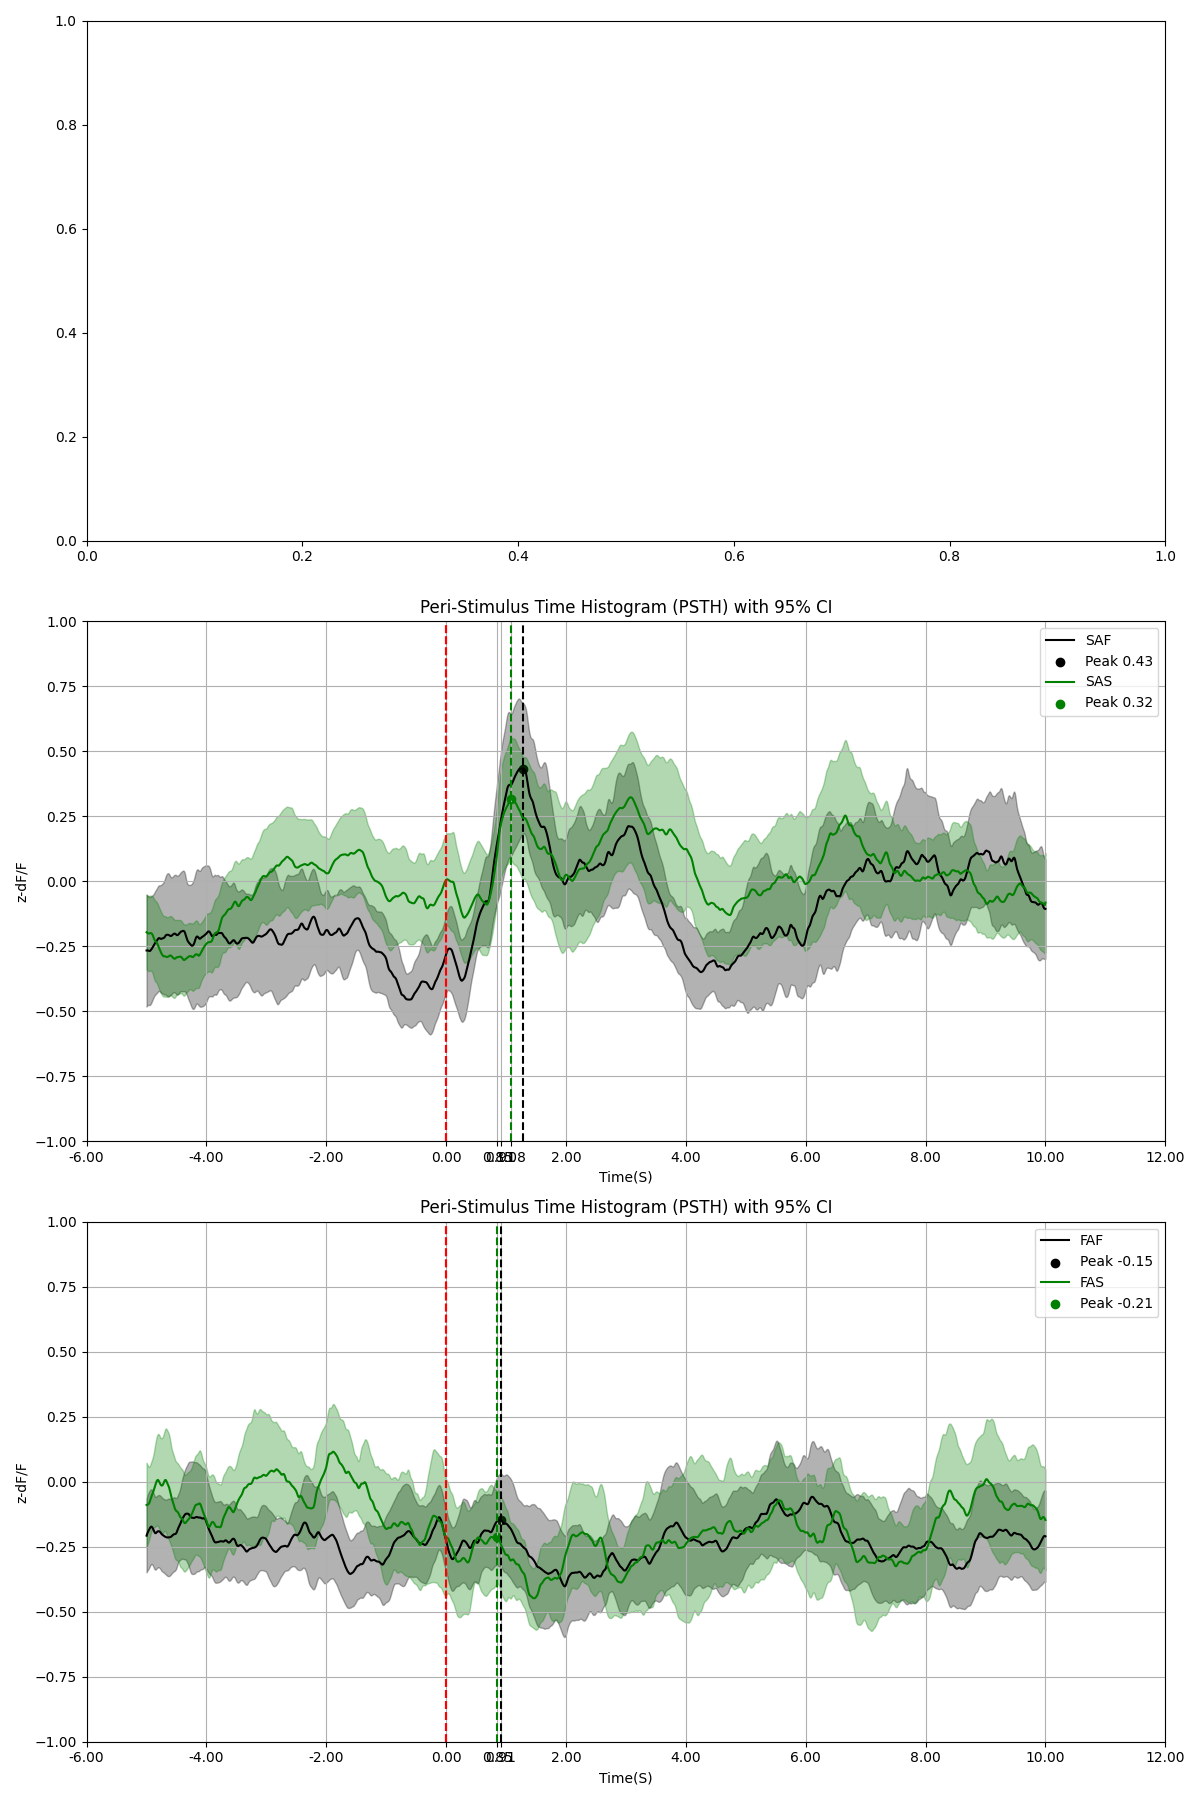

Figure saved as /home/coder/project/doric_fiberphotometry/Data/knob/315_NAc_knob_May6_0000_153516554_incomplete/Figs/PSTH.svg


In [17]:
import photometry_functions as pf
import os
from importlib import reload

reload(pf)

PSTH_df_ci_FAF = pf.create_psth_with_ci(normalized_signal_df_FAF)
PSTH_df_ci_FAS = pf.create_psth_with_ci(normalized_signal_df_FAS)
PSTH_df_ci_SAF = pf.create_psth_with_ci(normalized_signal_df_SAF)
PSTH_df_ci_SAS = pf.create_psth_with_ci(normalized_signal_df_SAS)


# Create a figure and a 3x1 grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))


pf.plot_psth(PSTH_df_ci_FAF, -1, 1,'black','FAF',pos=axs[2])
pf.plot_psth(PSTH_df_ci_FAS, -1, 1,'green','FAS',pos=axs[2])
pf.plot_psth(PSTH_df_ci_SAF, -1, 1,'black','SAF',pos=axs[1])
pf.plot_psth(PSTH_df_ci_SAS, -1, 1,'green','SAS',pos=axs[1])


plt.tight_layout()

plt.show()

filename = file_selector.file_path.split('.')[0]+'/Figs/'+'PSTH.svg'


directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

fig.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")


## HeatMap

In [ ]:
import photometry_functions as pf
import os
from importlib import reload

reload(pf)

filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/Heatmap_init.svg'
directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)


pf.heatmap_plot(normalized_signal_df_Init)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/Heatmap_Fail.svg'
pf.heatmap_plot(normalized_signal_df_Fail)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

filename = file_selector.file_path.split('.')[0]+'/Figs/'+'/Heatmap_Success.svg'
pf.heatmap_plot(normalized_signal_df_Success)
plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")


### Area Under Curves 

In [ ]:
import photometry_functions as pf
import fileselector as fs
import os
from importlib import reload
reload(fs)
reload(pf)
fs.load_dependencies()

# Success
plt.figure(figsize=(12, 6))

pf.plot_psth_auc(PSTH_df_std_Success,-2, 3.5,'green','Stim')
plt.show()
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'AUC_Success.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

pf.plot_auc_bars_with_duration(PSTH_df_std_Success,-1.5, 1.5,(-2,0),(0,5))
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'AUC_Bars_Success.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

# Fail
plt.figure(figsize=(12, 6))

pf.plot_psth_auc(PSTH_df_std_Fail,-2, 3.5,'green','Stim')
plt.show()
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'AUC_Fail.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")

pf.plot_auc_bars_with_duration(PSTH_df_std_Fail,-1.5, 1.5,(-2,0),(0,5))
filename = file_selector.file_path.split('.')[0]+'/Figs/'+'AUC_Bars_Fail.png'

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Figure saved as {filename}")



# saving all the Dataframes as CSV

In [ ]:
import pandas as pd
import datetime

def save_dataframes_to_csv():
    # Fetch the current datetime to append to file names to avoid overwriting
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = file_selector.file_path.split('.')[0]+'/Data/'+'test.csv"'
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    # Loop through all global variables
    for var_name, value in list(globals().items()):
        # Check if the value is an instance of pd.DataFrame
        if isinstance(value, pd.DataFrame):
            # Construct filename with a timestamp to prevent overwriting
            file = f"{var_name}_{now}.csv"
            filename = file_selector.file_path.split('.')[0]+'/Data/'+file

            # Save the DataFrame to a CSV file
            value.to_csv(filename, index=False)
            print(f"Saved {filename}")


# Call the function to save all DataFrames
save_dataframes_to_csv()


# reloading saved data

In [ ]:
import pandas as pd

def load_dataframe_from_csv(file_path):
    """
    Loads a DataFrame from a CSV file.

    Parameters:
    file_path (str): The path to the CSV file to be loaded.

    Returns:
    pandas.DataFrame: The DataFrame containing the data from the CSV file.
    """
    # Loading the DataFrame from the specified CSV file
    df = pd.read_csv(file_path)
    
    return df

# Example usage:
# Replace 'your_file.csv' with the path to the CSV file you want to load

csv_file_path = 'your_file.csv'
df = load_dataframe_from_csv(csv_file_path)
# Optionally, you can display the first few rows of the loaded DataFrame


In [ ]:
centralized_signals_df_Init


In [ ]:
import pandas as pd
import datetime
# Assuming centralized_signals_df_Init is your DataFrame

# If 'Event' is part of a MultiIndex, reset the index
if isinstance(centralized_signals_df_Init.index, pd.MultiIndex):
    centralized_signals_df_Init.reset_index(inplace=True)

# Filter the DataFrame for the base data at Time 0
# base_df = centralized_signals_df_Init[centralized_signals_df_Init['Time'] == 0]
# Filter the dataframe for the time range first
base_df = centralized_signals_df_Init[(centralized_signals_df_Init['Time'] >= -4) & (centralized_signals_df_Init['Time'] <= -2)]



base_df = base_df.groupby('Event')['Data'].mean().reset_index()
base_df.rename(columns={'Data': 'F_Init'}, inplace=True)

# Filter the DataFrame for Time values between 0 and 2
filtered_df = centralized_signals_df_Init[(centralized_signals_df_Init['Time'] >= 0) & (centralized_signals_df_Init['Time'] <= 2)]

# Group by 'Event' and find the maximum 'Data' value in each group
max_df = filtered_df.groupby('Event')['Data'].max().reset_index()
max_df.rename(columns={'Data': 'F_Max'}, inplace=True)

# Merge the base data and MaxdFF
result_df = pd.merge(base_df, max_df, on='Event', how='left')

# Calculate the difference between 'Max Data' and 'Base'
result_df['dFF'] = result_df['F_Max'] - result_df['F_Init']

# Calculate Init_Speed and Av_Speed
# Define time intervals for Init_Speed and Av_Speed calculations
init_interval_df = centralized_signals_df_Init[(centralized_signals_df_Init['Time'] >= 0) & (centralized_signals_df_Init['Time'] <= 0.1)]
av_interval_df = filtered_df  # already filtered from 0 to 2

# Group by 'Event' and calculate min and max 'Data' for Init_Speed
init_speed_calc = init_interval_df.groupby('Event')['Data'].agg(['min', 'max'])
init_speed_calc['F_Init_Speed'] = (init_speed_calc['max'] - init_speed_calc['min']) / 0.1

# Group by 'Event' and calculate min and max 'Data' for Av_Speed
av_speed_calc = av_interval_df.groupby('Event')['Data'].agg(['min', 'max'])
av_speed_calc['F_Av_Speed'] = (av_speed_calc['max'] - av_speed_calc['min']) / 2

# Merge these calculations into the result_df
result_df = result_df.merge(init_speed_calc[['F_Init_Speed']], on='Event', how='left')
result_df = result_df.merge(av_speed_calc[['F_Av_Speed']], on='Event', how='left')

# Save to CSV
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file = f"result_data_{now}.csv"
result_df.to_csv(file, index=False)
result_df.to_csv('result_data.csv', index=False)

# Print confirmation
print(f"The result has been saved to '{file}'.")


In [ ]:
import pandas as pd

# Simulating the creation of your initial DataFrame
data = {
    "Event": [1, 1, 1, 1, 1],
    "Row": [617, 618, 619, 620, 621],
    "Time": [-4.00, -3.99, -3.98, -3.97, -3.96],
    "Data": [0.330067, 0.341075, 0.356469, 0.363225, 0.341833]
}
centralized_signals_df_Init = pd.DataFrame(data)

# Define the time intervals
init_interval = (0, 0.1)
av_interval = (0, 2)

# Filter the DataFrame for the initial interval and calculate Init_Speed
init_data = centralized_signals_df_Init[(centralized_signals_df_Init['Time'] >= init_interval[0]) & (centralized_signals_df_Init['Time'] <= init_interval[1])]
if not init_data.empty:
    init_speed = (init_data['Data'].max() - init_data['Data'].min()) / (init_data['Time'].max() - init_data['Time'].min())
else:
    init_speed = 0

# Filter the DataFrame for the average interval and calculate Av_Speed
av_data = centralized_signals_df_Init[(centralized_signals_df_Init['Time'] >= av_interval[0]) & (centralized_signals_df_Init['Time'] <= av_interval[1])]
if not av_data.empty:
    av_speed = (av_data['Data'].max() - av_data['Data'].min()) / (av_data['Time'].max() - av_data['Time'].min())
else:
    av_speed = 0

# Assuming result_df exists and we can add columns to it
result_df['Init_Speed'] = init_speed
result_df['Av_Speed'] = av_speed

print(result_df)


In [ ]:
import pandas as pd

# Assuming centralized_signals_df_Init is your DataFrame

# Reset index if 'Event' is part of a MultiIndex
if isinstance(centralized_signals_df_Init.index, pd.MultiIndex):
    centralized_signals_df_Init.reset_index(inplace=True)

# Define function to calculate speed
def calculate_speed(df, start_time, end_time):
    # Filter data within the specified time range
    time_filtered = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]
    if time_filtered.empty:
        return float('nan')  # Return NaN if no data in the specified range
    else:
        # Calculate max and min data values
        max_value = time_filtered['Data'].max()
        min_value = time_filtered['Data'].min()
        # Calculate dt
        dt = end_time - start_time
        # Calculate speed
        return (max_value - min_value) / dt

result_df['Init_Speed'] = calculate_speed(centralized_signals_df_Init, 0, 0.1)
result_df['Av_Speed'] = calculate_speed(centralized_signals_df_Init, 0, 2)

# Save to CSV
result_df.to_csv('result_data_with_speeds.csv', index=False)

# Print confirmation
print("The result, including 'Init_Speed' and 'Av_Speed', has been saved to 'result_data_with_speeds.csv'.")
